<a href="https://colab.research.google.com/github/msafari18/Intelligent-Analysis-of-Biomedical-Images/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/My Drive/CT_Scan.zip" -d "/content/sample_data/Dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/Dataset/__MACOSX/CT_Scan/LungCT-Diagnosis/R_150/10-29-1997-Diagnostic Pre-Surgery Contrast Enhanced CT-48002/._2.000000- NONE -72790  
  inflating: /content/sample_data/Dataset/__MACOSX/CT_Scan/LungCT-Diagnosis/R_150/._10-29-1997-Diagnostic Pre-Surgery Contrast Enhanced CT-48002  
  inflating: /content/sample_data/Dataset/__MACOSX/CT_Scan/LungCT-Diagnosis/._R_150  
   creating: /content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/R_168/
   creating: /content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/R_168/09-19-1998-Diagnostic Pre-Surgery Contrast Enhanced CT-72187/
   creating: /content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/R_168/09-19-1998-Diagnostic Pre-Surgery Contrast Enhanced CT-72187/2.000000- NONE -44851/
  inflating: /content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/R_168/09-19-1998-Diagnostic Pre-Surgery Contrast Enhanced CT-72187/2.000000- NONE -44851/1-42.dcm  
   creating: /

In [1]:
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, Tanh
from torch.optim import Adam, SGD
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from random import shuffle
import matplotlib.pyplot as plt
!pip install pydicom
import pydicom
from pydicom.data import get_testdata_files
import os
import numpy as np
import time

In [2]:
def find_all_path(head_path = "/content/sample_data/Dataset/CT_Scan/LungCT-Diagnosis/"):
  array_pepole_ct = os.listdir(head_path)
  print("number of sample: ", len(array_pepole_ct))
  dic_files_DCM = {}
  for file_name in array_pepole_ct:
    f1 =  os.listdir(head_path+file_name)[0]
    f2 =  os.listdir(head_path+file_name+"/"+f1)[0]
    path = head_path+file_name+"/"+f1+"/"+f2
    temp = []
    for dirName, subdirList, fileList in os.walk(path):
      for filename in fileList:
          if ".dcm" in filename.lower(): 
              temp.append(os.path.join(dirName,filename))
  
    dic_files_DCM[file_name] = temp

  return dic_files_DCM

def load_sample_pixel(sample_path):

  ct_scan = pydicom.read_file(sample_path[0])
  ConstPixelDims = (int(ct_scan.Rows), int(ct_scan.Columns), len(sample_path))
  array_dicom = np.zeros(ConstPixelDims, dtype=ct_scan.pixel_array.dtype)
  
  array_dicom_file = [pydicom.read_file(i) for i in sample_path]
  array_dicom_file.sort(key = lambda x: int(x.InstanceNumber))  
  for n, ct_scan in enumerate(array_dicom_file):  
    array_dicom[:,:,n] = ct_scan.pixel_array
  
  return array_dicom


t1 = time.time()
all_sample_dicom = find_all_path()
all_sample_dicom_pixel = {}

for j in list(all_sample_dicom):
  patient_id = j.replace("R","Patient")
  array_dicom = load_sample_pixel(all_sample_dicom[j])
  all_sample_dicom_pixel[patient_id] = array_dicom

t2 = time.time()
print(t2 - t1)


number of sample:  61
80.63087248802185


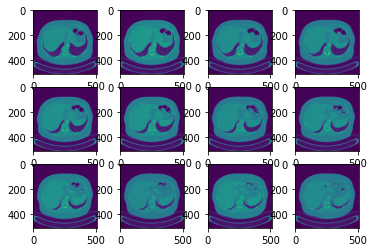

In [4]:
import cv2

fig = plt.figure()
list_dicom  = []
for n, _ in  enumerate(all_sample_dicom_pixel["Patient_069"]):
  list_dicom.append(np.array(all_sample_dicom_pixel["Patient_069"][:,:,n+80]))
  if n >= 11:
    break

IMG_PX_SIZE =  512
for num,each_slice in enumerate(list_dicom):
    y = fig.add_subplot(3,4,num+1)
    new_img = cv2.resize(np.array(each_slice),(IMG_PX_SIZE,IMG_PX_SIZE))
    y.imshow(new_img)
plt.show()

In [6]:

https://pythonprogramming.net/3d-convolutional-neural-network-machine-learning-tutorial/
https://www.kaggle.com/akh64bit/full-preprocessing-tutorial
https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/


SyntaxError: ignored

In [5]:
import math
from scipy import ndimage

def chunks(l, n):
  list_ = []
  for i in range(0, l.shape[2], n):
    list_.append(l[:,:,i:i + n])
  return list_

def mean(images):
  return np.sum(images,axis = 2)/images.shape[2]

IMG_PX_SIZE = 256

def resize_images(all_sample_dicom_pixel, ch_size):
  ConstPixelDims = (IMG_PX_SIZE, IMG_PX_SIZE, ch_size)
  array_dicom = np.zeros(ConstPixelDims)
  resized_image = {}
  for i in all_sample_dicom_pixel:
    image = cv2.resize(np.array(all_sample_dicom_pixel[i]),(IMG_PX_SIZE,IMG_PX_SIZE))
    chunk = chunks(image,math.ceil(image.shape[2]/ch_size))
    for n,j in enumerate(chunk):
      array_dicom[:,:,n] = mean(j)
    if array_dicom.shape[2] < ch_size:
      array_dicom[:,:,len(chunk):] = image[:,:,-(ch_size-len(chunk)):]
    
    resized_image[i] = array_dicom
  
  return resized_image

def normalize(img):
  min = -1000
  max = 400
  img[img < min] = min
  img[img > max] = max
  img = (img - min) / (max - min)
  normalized = img.astype("float32")
  
  return normalized

def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

resized_img = {}
for n, j in enumerate(list(all_sample_dicom_pixel)):
  # normalized = normalize(np.array(all_sample_dicom_pixel[j]))  
  resized_array_dicom = resize_volume(np.array(all_sample_dicom_pixel[j]))
  resized_img[j] = resized_array_dicom
  

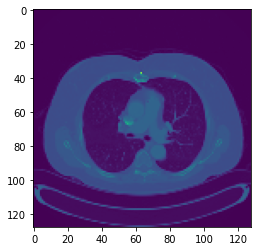

In [6]:
# fig = plt.figure()

# for num in range(9):
#     y = fig.add_subplot(3,3,num+1)
#     y.imshow(resized_img["Patient_069"][:,:,num+9])
# plt.show()

plt.imshow(resized_img["Patient_069"][:,:,20])

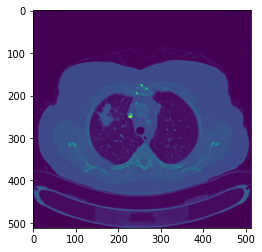

In [7]:
plt.imshow(all_sample_dicom_pixel["Patient_069"][:,:,20])

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import sklearn
import tensorflow as tf


@tf.function
def rotate(volume, angle):
  
  def scipy_rotate(volume, angle):
    volume = ndimage.rotate(volume, angle, reshape=False)
    return volume

  augmented_volume = tf.numpy_function(scipy_rotate, [volume, angle], tf.float32)
  return augmented_volume


def agumentation(X_train, y_train, repeat = 3):

  new_X_train = [tf.expand_dims(img.astype(np.float32), axis=3) for img in X_train]
  new_y_train = [label for label in y_train]

  for img,label in zip(X_train,y_train):
    angles = [-20, -15, -10, -5, 5, 10, 15, 20]
    for j in range(repeat):
      angle = random.choice(angles)
      img_r = rotate(img.astype(np.float32), angle)
      img_new = tf.expand_dims(img_r, axis=3)
      new_X_train.append(img_new)
      new_y_train.append(label)
      angles.remove(angle)

  new_y_train = np.array(new_y_train)
  return new_X_train, new_y_train
    
# # X_train = np.array(X_train)
# y_train = np.array(y_train)
# print(len(X_train),len(y_train))


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def get_model(width=128, height=128, depth=24):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", name = "conv1")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", name = "conv2")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", name = "conv3")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu", name = "conv4")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.1)(x)

    outputs = layers.Dense(units=2, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv2 (Conv3D)               (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3 (Conv3D)               (None, 61, 61, 29, 128)   221312    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 30, 30, 14, 128)   0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 14, 128)   512   

In [12]:
labels = pd.read_csv("/content/sample_data/label.txt", sep = '\t', header = None)
labels.columns = ["patient_id","status"]

p_id = [i for i in labels["patient_id"] if i != "Patient_260"]
p_status = [i for i in labels["status"]]

X = np.array([resized_img[i] for i in p_id])
y = np.array([int(j.split(" ")[0]) for i, j in zip(p_id, p_status)])

print(len(X), len(y))


61 61


In [14]:
from sklearn.model_selection import StratifiedKFold


initial_learning_rate = 0.0001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
# )
epochs = 55
batch_size = 2
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
cvscores = []
best_model = get_model(width=128, height=128, depth=64)  
best_score = -343434
# print(y.shape)
loss_train = []
loss_val = []
acc_train = []
acc_val = []
x = 0
best_model_num = 0
for train, test in kfold.split(X, y):
  x+=1
  X_train, y_train = agumentation(X[train], y[train])
  X_train, y_train = sklearn.utils.shuffle(X_train, y_train)
  y_train = np.array([[1,0] if i == 0 else [0,1] for i in y_train])

  train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train.astype(np.float32)))
  train_dataset = (train_loader.shuffle(len(X_train)).batch(batch_size).prefetch(2))

  model = get_model(width=128, height=128, depth=64)
  model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["acc"],)
  history = model.fit(train_dataset, epochs=epochs, shuffle=True, verbose=2)
  loss_train.append(history.history['loss'])
  acc_train.append(history.history['acc'])

  y_test = np.array([[1,0] if i == 0 else [0,1] for i in y[test]])
  test_loader = tf.data.Dataset.from_tensor_slices((X[test], y_test))
  test_dataset = (test_loader.shuffle(len(X[test])).batch(batch_size).prefetch(2))
  scores = model.evaluate(test_dataset, verbose=0)
  if scores[1] * 100 > best_score:
    best_score = scores[1] * 100
    best_model = model
    best_model_num = x
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  acc_val.append(scores[1]*100)

  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("best score: ^^",best_score)

Epoch 1/55
96/96 - 21s - loss: 0.7569 - acc: 0.5104
Epoch 2/55
96/96 - 21s - loss: 0.7573 - acc: 0.5938
Epoch 3/55
96/96 - 21s - loss: 0.6851 - acc: 0.5573
Epoch 4/55
96/96 - 21s - loss: 0.6628 - acc: 0.6094
Epoch 5/55
96/96 - 21s - loss: 0.6569 - acc: 0.6302
Epoch 6/55
96/96 - 21s - loss: 0.6390 - acc: 0.6458
Epoch 7/55
96/96 - 21s - loss: 0.6099 - acc: 0.6510
Epoch 8/55
96/96 - 21s - loss: 0.6373 - acc: 0.6354
Epoch 9/55
96/96 - 21s - loss: 0.6452 - acc: 0.6146
Epoch 10/55
96/96 - 21s - loss: 0.6208 - acc: 0.6406
Epoch 11/55
96/96 - 21s - loss: 0.5873 - acc: 0.6250
Epoch 12/55
96/96 - 21s - loss: 0.6628 - acc: 0.5938
Epoch 13/55
96/96 - 21s - loss: 0.5735 - acc: 0.7188
Epoch 14/55
96/96 - 21s - loss: 0.5719 - acc: 0.6562
Epoch 15/55
96/96 - 21s - loss: 0.5914 - acc: 0.6979
Epoch 16/55
96/96 - 21s - loss: 0.5559 - acc: 0.7344
Epoch 17/55
96/96 - 21s - loss: 0.5396 - acc: 0.7292
Epoch 18/55
96/96 - 21s - loss: 0.5530 - acc: 0.7031
Epoch 19/55
96/96 - 21s - loss: 0.5358 - acc: 0.7135
Ep

3


Text(0.5, 1.0, 'Train loss')

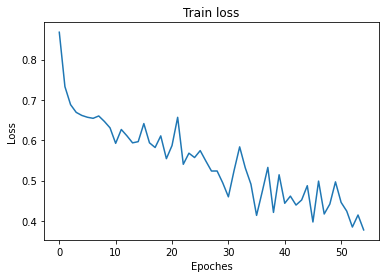

In [20]:
plt.plot([i for i in range(55)],loss_train[2])
print(best_model_num)
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.title("Train loss")
# print(X[test][0].shape)
# model.predict(np.array(X[test]))
# for i in range(12):
#   print(np.argmax(model.predict(np.array([X[test][i]]))))

# print(y[test])

In [17]:
from keras import backend as K

def visualize_class_activation_map(model, img):
        img = np.array([np.transpose(np.float32(img), (0, 1,2))])
        class_weights = model.layers[-1].get_weights()[0]
        # print("class w:",class_weights.shape)
        final_conv_layer = model.get_layer('conv4')
        
        get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
        # print(np.array([img]).shape)
        new_img = np.array([img])
        new_img = new_img.reshape((1, 128, 128, 64,1))
        # print("input shape:",new_img.shape)
        [conv_outputs, predictions] = get_output(new_img)
        # print("conv output shape:", conv_outputs.shape)
        print("k",predictions)
        conv_outputs = conv_outputs[0,:, :, :] 
        # print("conv output shape:", conv_outputs.shape)
        
        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[:-1])
        # print("cam shape",cam.shape)
        target_class = 1
        
        # print(class_weights[:,1])
        for i, w in enumerate(class_weights[:256,1]):
          # print(cam.shape)
          # print(w.shape)
          # print(conv_outputs.shape)
          # if i >= 12:
            # break  
          cam += abs(w) * conv_outputs[:,:,:,i]
          return cam

# print(cam)
cam = visualize_class_activation_map(model, X[test][0])
print("cam : ",cam.shape)

k [[0.03099572 0.9690043 ]]
cam :  (28, 28, 12)


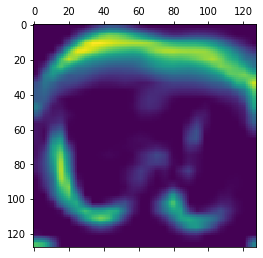

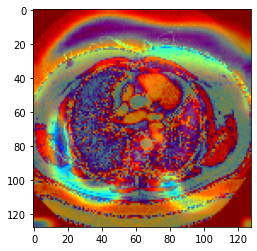

In [18]:
from skimage import exposure 
import cv2

heatmap = np.mean(cam, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (128, 128))

plt.matshow(heatmap)
plt.show()


img_first = resized_img[p_id[9]][:,:,20]
u8 = img_first.astype(np.uint8)
img = cv2.applyColorMap(u8, cv2.COLORMAP_JET)
map_img = exposure.rescale_intensity(heatmap, out_range=(0, 255))
map_img = np.uint8(map_img)
heatmap_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)
fin = cv2.addWeighted(heatmap_img, 0.5, img, 0.5, 0)
plt.imshow(fin)

# plt.imshow(img)

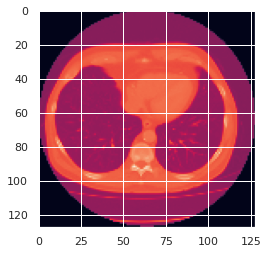

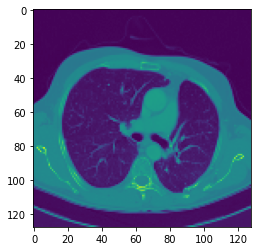

In [24]:
plt.imshow(X[test][0][:,:,20])

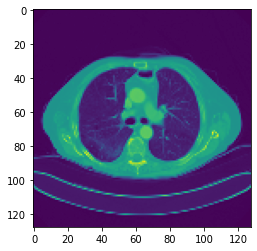

In [29]:
plt.imshow(X[test][1][:,:,20])

In [33]:
print(y)

[1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1
 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1]


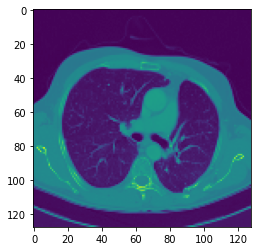

In [36]:
plt.imshow(X[2][:,:,20])

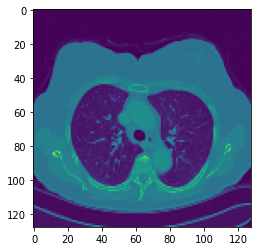

In [42]:
plt.imshow(X[11][:,:,20])

Patient_035
1


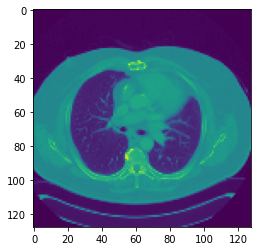

In [47]:
# for n,i in enumerate(p_id):
print(p_id[9])
print(y[9])
plt.imshow(resized_img[p_id[9]][:,:,20])

In [ ]:
ndimage.zoom([], (width_factor, height_factor, depth_factor), order=1)